# Classifying Actuarial Data with LLMs

## Introduction

Large Language Models (LLMs) are increasingly playing a role in all types of office-based work, with actuarial being no exception. According to one recent study by the SOA [https://www.soa.org/4ac5cf/globalassets/assets/files/resources/research-report/2025/2025-11-ait-172-ai-quarter-survey-report.pdf] actuaries are currently most likely to use LLMs in the following ways:
- Brainstorming
- Writing and Interpreting Documents
- Chatbots
- Code Generation 

In this article, we consider a use case for an actuary to save on one of the more time-consuming tasks an actuary might experience. **Data Cleansing**. 

Normally data cleansing is carried out by code, data manipulation or in some cases manually. But occassionally our data is just too messy, nuanced and large for these options. It is possible to build a pipeline within Python, where new data is cleansed by an LLM. We present the results of this solution on a case study below. We also explore some more advanced techniques for getting the most out of our LLM.

## Initial Case Study

For this case study we have taken the ICD-10 causes of death as our dataset. There are thousands of causes of death in here, but we want to classify them into a small group of broader categories. The broader categories we have pulled from a paper online related to the cause-specific mortality impact of smoking [https://pmc.ncbi.nlm.nih.gov/articles/PMC3229033/]. To make our ICD-10 causes of death compatible with the hazard ratios in this paper, we wish to classify each of them into one of:

    "ischaemic heart disease"
    "cerebrovascular disease"
    "pulmonary disease"
    "lung cancer"
    "colorectal cancer"
    "larynx cancer"
    "kidney cancer"
    "acute myeloid leukemia"
    "oral cavity cancer"
    "esophageal cancer"
    "pancreatic cancer"
    "bladder cancer"
    "stomach cancer"
    "prostate cancer"
    "none"

To get a measure of the results, we also attempted this classification piece ourselves. We should caveate that our estimates are our own best guesses, and may be incorrect in places. After all, to err is human!

We got some initial results through from the OpenAI gpt-o4 model. In general performance was quite strong, with an accuracy of [INSERT ACCURACY]. The performance is summarised below

In [7]:
# Table with TRUE/FALSE POSITIVE/NEGATIVE counts, as well as precision, recall and F1 scores 
# (i.e. table 3 in https://paulbeardactuarial.github.io/artificial_actuary_cod.html, but with gpt-4o)


## Logprobs 

*"To know what you know and what you do not know, that is true knowledge"* 
- Confucius

In our case study we completed the task manually so that we could analyse the results. This is useful for testing, but would defeat the purpose in a production setting. How can we get confidence in the LLM answers, without breathing down its neck and reviewing all of it's work?

LLMs, in a nutshell, are models that predict the next token in sequence. Each token chosen by the model had a probability of being next in the sequence. In some cases the token can have a very high probability attached, for example the sentence "Once upon a ..." will almost always be follwed with "time". Other cases are more ambiguous, such as the sentence "The plane landed in ..." having many plausible endings. 

When talking to ChatGPT through Python, we can use the `logprobs` feature to return the (log) probabilty of each token in the response. By transforming this output, we can get a confidence score for each classification that was preformed by the LLM. 

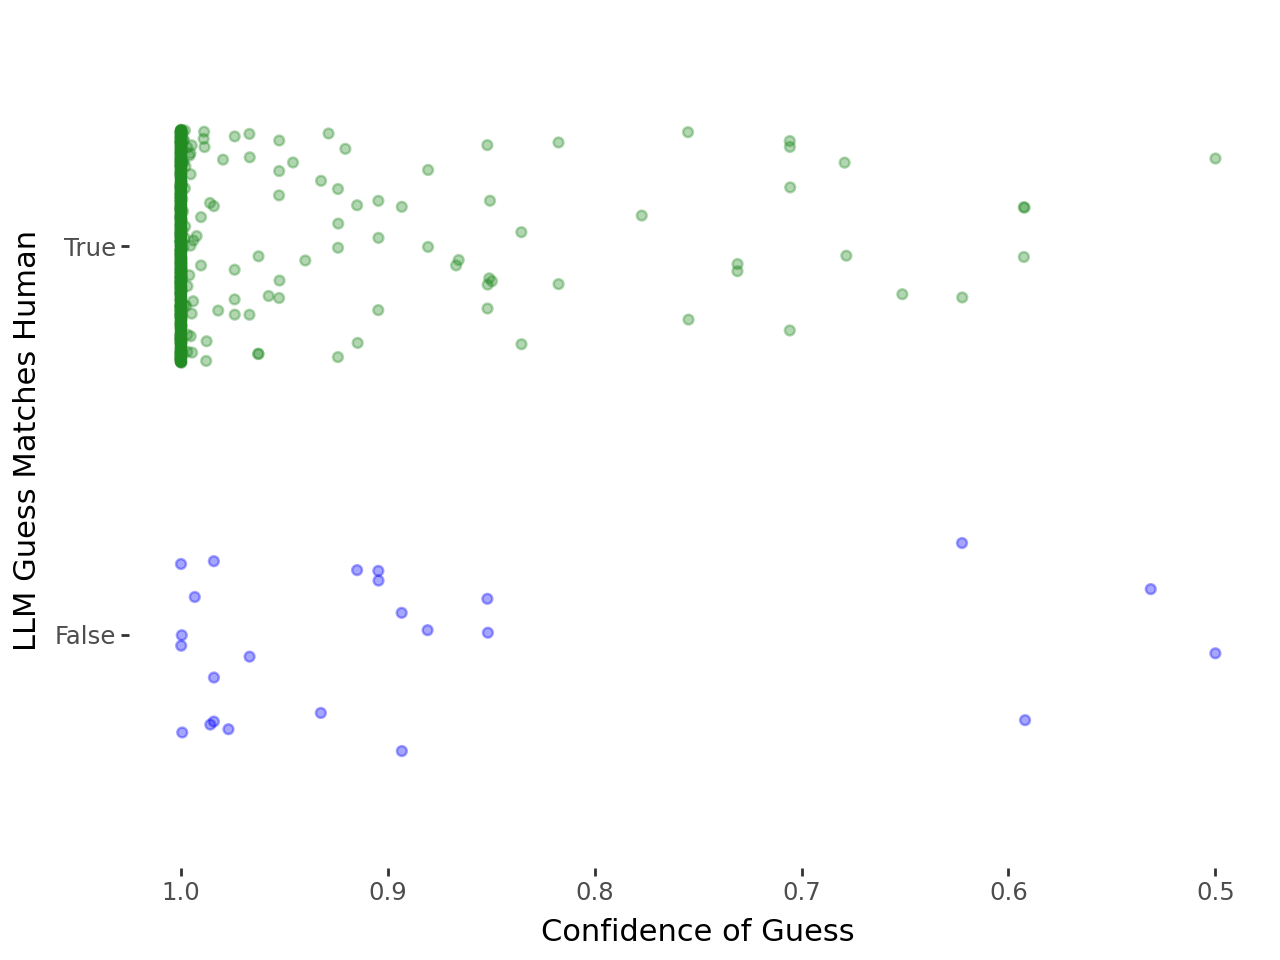

In [8]:

import pandas as pd
import numpy as np
from pathlib import Path
import great_tables as gt
from plotnine import *
np.random.seed(123)

# Human predictions
human_pred_csv = Path("./Data/cause_of_death.csv")
cod_df = pd.read_csv(human_pred_csv)
hm_df = cod_df[cod_df["train_test"] == "test"][[
    "cause_of_death", "category_human"]]

# AI predictions with logprobs
llm_pred_csv = "output_openai_gpt_4o_logprobs"
output_csv_path = Path("./Data/output_gpt_4o_base.csv")
lp_df = pd.read_csv(output_csv_path)
cols_keep = ["cause_of_death", "category", "confidence"]
lp_df = lp_df.loc[:, cols_keep]

# Compare
rec = pd.merge(hm_df, lp_df, on="cause_of_death")
rec["match"] = rec["category_human"] == rec["category"]

# Plot
(ggplot(rec, aes(y="confidence", x="match", color="match")) +
    geom_jitter(width=0.3, alpha=0.35) +
    coord_flip() +
    scale_y_reverse() +
    xlab("LLM Guess Matches Human") +
    ylab("Confidence of Guess") +
    scale_color_manual(values={True: "forestgreen", False: "blue"}) +
    theme_bw() +
    theme(
        legend_position="none",
        axis_line=element_blank(),      # removes axis lines (flip-safe)
        panel_border=element_blank(),   # removes plot outline
        panel_grid=element_blank()
)
)

The LLM can tell us which answers it was confident in, and which were more ambigious. Is this useful? It turns out, yes. For the majority of the answers returned, the LLM was very confident. We also find the error rate is extremely low for these cases. When the confidence dropped, the chance of disagreement between the LLM and human was materially higher. 

We can use this as a targetted way to focus on which LLM results we might want to review, and which we are willing to blindly accept for the sake of efficiency. In the table below we cut the data into two groups based on the confidence (above or below 99%). For the high confidence group, the accuracy is 99.5%. For the less confident group, accuracy is below 80%. As there are only 90 of our 1,000 datapoints in this group, manual oversight becomes a more manageable task.

In [11]:
rec["confidence_band"] = pd.cut(rec["confidence"], bins=[0, 0.99, 1.0])

accuracy_df = rec.groupby("confidence_band", observed=False)[
    "match"].aggregate(["count", "sum", "mean"])

accuracy_gt = gt.GT(accuracy_df.reset_index())
accuracy_gt = accuracy_gt.fmt_percent(["mean"], decimals=1)

(accuracy_gt.cols_label(
    {
        "confidence_band": "Confidence",
        "count": "Attempts",
        "sum": "Matches",
        "mean": "Accuracy"
    }
)
)

Confidence,Attempts,Matches,Accuracy
"(0.0, 0.99]",90,71,78.9%
"(0.99, 1.0]",910,905,99.5%


## Fine-tuning 

*"Practice makes perfect"* 
- Anonymous

So far we have been using LLMs straight out-of-the-box. Although these LLMs are incredibly powerful and flexible, we are subject to the responses under factory settings. We can "prompt engineer" to push in the directions we want, but this

In [10]:
# fine tuning results

## Biasing 

*"...nonenonenonenonenonenonenone..."* 
- gpt-4o with "none" bias of 100

In our cas